In [1]:
import os
import torch
from tqdm import tqdm
import numpy as np
import io

import matplotlib.pyplot as plt
from utils import setup_seed
from dataset import Kitti, get_dataloader
from model import PointPillars
from loss import Loss
from tensorboardX import SummaryWriter
import cv2
import io


import argparse
import os
import torch
from tqdm import tqdm
import pdb
import numpy as np

import matplotlib.pyplot as plt
from utils import setup_seed, keep_bbox_from_image_range, \
    keep_bbox_from_lidar_range, write_pickle, write_label, \
    iou2d, iou3d_camera, iou_bev
from dataset import Kitti, get_dataloader
from model import PointPillars
from loss import Loss


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Function to plot the scalars and convert the plot to a tensor image
def plot_scalars(scalars, step):
    fig, ax = plt.subplots()
    ax.plot(scalars)
    ax.set_title(f'Step {step}')
    ax.set_xlabel('Scalar Index')
    ax.set_ylabel('Value')
    plt.grid(True)

    # Convert the plot to a PNG image
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)

    # Convert PNG buffer to a tensor image
    image = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)  # Decode the image
    image = torch.from_numpy(image).permute(2, 0, 1)#.unsqueeze(0)  # Convert to PyTorch tensor and add batch dimension
    return image

def save_summary(writer, loss_dict, global_step, tag, gating_prob, lr=None, momentum=None, model=None, data=None, flag=False):
    for k, v in loss_dict.items():
        writer.add_scalar(f'{tag}/{k}', v, global_step)
    if lr is not None:
        writer.add_scalar('lr', lr, global_step)
    if momentum is not None:
        writer.add_scalar('momentum', momentum, global_step)
    if model is not None and global_step % 1000 == 0:
        for tag, value in model.named_parameters():
            # import pdb
            # pdb.set_trace()
            if value.grad is not None:
                writer.add_histogram(tag + "/grad", value.grad.cpu(), global_step)
    
    if global_step % 100 == 0:
        image = plot_scalars(gating_prob.detach().cpu().numpy(), global_step)
        writer.add_image("Scalars Plot", image, global_step=global_step)
    # for i in data:
    #     del i['gt_names']
    #     del i['image_info']
    #     del i['calib_info']
    #     del i['difficulty']

    # writer.add_graph(model, data)



### Training Arguments

In [3]:
class Args:
    def __init__(self):
        self.data_root = "dataset/KITTI"
        self.saved_path = "logs/pillar_sequence_mem_lin_gat_4"
        self.saved_path_exact = self.saved_path + "/results_exact"
        self.saved_path_estimate = self.saved_path + "/results_estimate"
        self.batch_size = 1
        self.num_workers = 4
        self.nclasses = 3
        self.init_lr = 0.00025
        self.max_epoch = 200
        self.log_freq = 1        
        self.ckpt_freq_epoch = 2
        self.val_freq_epoch = 5
        self.no_cuda = not torch.cuda.is_available()
 
args = Args()

### Dataloader

In [4]:
def send_to_cuda(d):
    for key, value in d.items():
        if isinstance(value, np.ndarray):
            # Check if the NumPy array contains a supported type
            if value.dtype in [np.float64, np.float32, np.float16, np.int64, np.int32, np.int16, np.int8, np.uint8, np.bool_]:
                value = torch.tensor(value)
        if isinstance(value, torch.Tensor):
            d[key] = value.cuda()
    return d

# Send all tensors in the list of dictionaries to CUDA
# list_of_dicts_cuda = [send_to_cuda(d) for d in data]

# # Verify that the tensors are on CUDA
# for d in list_of_dicts_cuda:
#     for key, value in d.items():
#         if isinstance(value, torch.Tensor):
#             print(f'{key}: {value.device}')  # Should print 'cuda:0' or another cuda device
#         else:
#             print(f'{key}: {value}')  # Print non-tensor values as is

setup_seed()
train_dataset = Kitti(data_root=args.data_root,
                        split='train',
                        timelength=10)
val_dataset = Kitti(data_root=args.data_root,
                    split='val',
                    timelength=1)

# data = train_dataset.__getitem__(9)

train_dataset_length = len(train_dataset.sorted_ids)
train_dataset_batch_count =  train_dataset_length // train_dataset.timelength
val_dataset_length = len(val_dataset.sorted_ids)

def get_sequence_from_velodyne_path(file_path):
    parts = file_path.split('/')
    file_name = parts[-1]
    extracted_part = file_name.split('_')[0]
    return extracted_part

# Print the extracted part

CLASSES = Kitti.CLASSES
LABEL2CLASSES = {v:k for k, v in CLASSES.items()}


pcd_limit_range = np.array([0, -40, -3, 70.4, 40, 0.0], dtype=np.float32)


### Model, Loss, Optimizer, Scheduler, Log

In [5]:
if not args.no_cuda:
    pointpillars = PointPillars(nclasses=args.nclasses).cuda()
else:
    pointpillars = PointPillars(nclasses=args.nclasses)

model_flag = False

loss_func = Loss()

max_iters = 2* train_dataset_batch_count * args.max_epoch
init_lr = args.init_lr
optimizer = torch.optim.AdamW(params=pointpillars.parameters(), 
                                lr=init_lr, 
                                betas=(0.95, 0.99),
                                weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,  
                                                max_lr=init_lr*10, 
                                                total_steps=max_iters, 
                                                pct_start=0.4, 
                                                anneal_strategy='cos',
                                                cycle_momentum=True, 
                                                base_momentum=0.95*0.895, 
                                                max_momentum=0.95,
                                                div_factor=10)


saved_logs_path = os.path.join(args.saved_path, 'summary')
import shutil
if os.path.exists(saved_logs_path):
    shutil.rmtree(saved_logs_path)
os.makedirs(saved_logs_path, exist_ok=True)
writer = SummaryWriter(saved_logs_path)
saved_ckpt_path = os.path.join(args.saved_path, 'checkpoints')
os.makedirs(saved_ckpt_path, exist_ok=True)

# Directory for exact results
saved_path_exact = args.saved_path_exact
os.makedirs(saved_path_exact, exist_ok=True)
saved_submit_path_exact = os.path.join(saved_path_exact, 'submit')
os.makedirs(saved_submit_path_exact, exist_ok=True)

# Directory for estimate results
saved_path_estimate = args.saved_path_estimate
os.makedirs(saved_path_estimate, exist_ok=True)
saved_submit_path_estimate = os.path.join(saved_path_estimate, 'submit')
os.makedirs(saved_submit_path_estimate, exist_ok=True)


### Validation Stuff

In [6]:
def get_score_thresholds(tp_scores, total_num_valid_gt, num_sample_pts=41):
    score_thresholds = []
    tp_scores = sorted(tp_scores)[::-1]
    cur_recall, pts_ind = 0, 0
    for i, score in enumerate(tp_scores):
        lrecall = (i + 1) / total_num_valid_gt
        rrecall = (i + 2) / total_num_valid_gt

        if i == len(tp_scores) - 1:
            score_thresholds.append(score)
            break

        if (lrecall + rrecall) / 2 < cur_recall:
            continue

        score_thresholds.append(score)
        pts_ind += 1
        cur_recall = pts_ind / (num_sample_pts - 1)
    return score_thresholds

In [7]:
def do_eval(det_results, gt_results, CLASSES, saved_path):
    '''
    det_results: list,
    gt_results: dict(id -> det_results)
    CLASSES: dict
    '''
    assert len(det_results) == len(gt_results)
    f = open(os.path.join(saved_path, 'eval_results.txt'), 'w')

    # 1. calculate iou
    ious = {
        'bbox_2d': [],
        'bbox_bev': [],
        'bbox_3d': []
    }
    ids = list(sorted(gt_results.keys()))
    for id in ids:
        gt_result = gt_results[id]['annos']
        det_result = det_results[id]

        # 1.1, 2d bboxes iou
        gt_bboxes2d = gt_result['bbox'].astype(np.float32)
        det_bboxes2d = det_result['bbox'].astype(np.float32)
        iou2d_v = iou2d(torch.from_numpy(gt_bboxes2d).cuda(), torch.from_numpy(det_bboxes2d).cuda())
        ious['bbox_2d'].append(iou2d_v.cpu().numpy())

        # 1.2, bev iou
        gt_location = gt_result['location'].astype(np.float32)
        gt_dimensions = gt_result['dimensions'].astype(np.float32)
        gt_rotation_y = gt_result['rotation_y'].astype(np.float32)
        det_location = det_result['location'].astype(np.float32)
        det_dimensions = det_result['dimensions'].astype(np.float32)
        det_rotation_y = det_result['rotation_y'].astype(np.float32)

        gt_bev = np.concatenate([gt_location[:, [0, 2]], gt_dimensions[:, [0, 2]], gt_rotation_y[:, None]], axis=-1)
        det_bev = np.concatenate([det_location[:, [0, 2]], det_dimensions[:, [0, 2]], det_rotation_y[:, None]], axis=-1)
        iou_bev_v = iou_bev(torch.from_numpy(gt_bev).cuda(), torch.from_numpy(det_bev).cuda())
        ious['bbox_bev'].append(iou_bev_v.cpu().numpy())

        # 1.3, 3dbboxes iou
        gt_bboxes3d = np.concatenate([gt_location, gt_dimensions, gt_rotation_y[:, None]], axis=-1)
        det_bboxes3d = np.concatenate([det_location, det_dimensions, det_rotation_y[:, None]], axis=-1)
        iou3d_v = iou3d_camera(torch.from_numpy(gt_bboxes3d).cuda(), torch.from_numpy(det_bboxes3d).cuda())
        ious['bbox_3d'].append(iou3d_v.cpu().numpy())

    MIN_IOUS = {
        'Pedestrian': [0.5, 0.5, 0.5],
        'Cyclist': [0.5, 0.5, 0.5],
        'Car': [0.7, 0.7, 0.7]
    }
    MIN_HEIGHT = [40, 25, 25]

    overall_results = {}
    for e_ind, eval_type in enumerate(['bbox_2d', 'bbox_bev', 'bbox_3d']):
        eval_ious = ious[eval_type]
        eval_ap_results, eval_aos_results = {}, {}
        for cls in CLASSES:
            eval_ap_results[cls] = []
            eval_aos_results[cls] = []
            CLS_MIN_IOU = MIN_IOUS[cls][e_ind]
            for difficulty in [0, 1, 2]:
                # 1. bbox property
                total_gt_ignores, total_det_ignores, total_dc_bboxes, total_scores = [], [], [], []
                total_gt_alpha, total_det_alpha = [], []
                for id in ids:
                    gt_result = gt_results[id]['annos']
                    det_result = det_results[id]

                    # 1.1 gt bbox property
                    cur_gt_names = gt_result['name']
                    cur_difficulty = gt_result['difficulty']
                    gt_ignores, dc_bboxes = [], []
                    for j, cur_gt_name in enumerate(cur_gt_names):
                        ignore = cur_difficulty[j] < 0 or cur_difficulty[j] > difficulty
                        if cur_gt_name == cls:
                            valid_class = 1
                        elif cls == 'Pedestrian' and cur_gt_name == 'Person_sitting':
                            valid_class = 0
                        elif cls == 'Car' and cur_gt_name == 'Van':
                            valid_class = 0
                        else:
                            valid_class = -1
                        
                        if valid_class == 1 and not ignore:
                            gt_ignores.append(0)
                        elif valid_class == 0 or (valid_class == 1 and ignore):
                            gt_ignores.append(1)
                        else:
                            gt_ignores.append(-1)
                        
                        if cur_gt_name == 'DontCare':
                            dc_bboxes.append(gt_result['bbox'][j])
                    total_gt_ignores.append(gt_ignores)
                    total_dc_bboxes.append(np.array(dc_bboxes))
                    total_gt_alpha.append(gt_result['alpha'])

                    # 1.2 det bbox property
                    cur_det_names = det_result['name']
                    cur_det_heights = det_result['bbox'][:, 3] - det_result['bbox'][:, 1]
                    det_ignores = []
                    for j, cur_det_name in enumerate(cur_det_names):
                        if cur_det_heights[j] < MIN_HEIGHT[difficulty]:
                            det_ignores.append(1)
                        elif cur_det_name == cls:
                            det_ignores.append(0)
                        else:
                            det_ignores.append(-1)
                    total_det_ignores.append(det_ignores)
                    total_scores.append(det_result['score'])
                    total_det_alpha.append(det_result['alpha'])

                # 2. calculate scores thresholds for PR curve
                tp_scores = []
                for i, id in enumerate(ids):
                    cur_eval_ious = eval_ious[i]
                    gt_ignores, det_ignores = total_gt_ignores[i], total_det_ignores[i]
                    scores = total_scores[i]

                    nn, mm = cur_eval_ious.shape
                    assigned = np.zeros((mm, ), dtype=np.bool_)
                    for j in range(nn):
                        if gt_ignores[j] == -1:
                            continue
                        match_id, match_score = -1, -1
                        for k in range(mm):
                            if not assigned[k] and det_ignores[k] >= 0 and cur_eval_ious[j, k] > CLS_MIN_IOU and scores[k] > match_score:
                                match_id = k
                                match_score = scores[k]
                        if match_id != -1:
                            assigned[match_id] = True
                            if det_ignores[match_id] == 0 and gt_ignores[j] == 0:
                                tp_scores.append(match_score)
                total_num_valid_gt = np.sum([np.sum(np.array(gt_ignores) == 0) for gt_ignores in total_gt_ignores])
                score_thresholds = get_score_thresholds(tp_scores, total_num_valid_gt)    
            
                # 3. draw PR curve and calculate mAP
                tps, fns, fps, total_aos = [], [], [], []

                for score_threshold in score_thresholds:
                    tp, fn, fp = 0, 0, 0
                    aos = 0
                    for i, id in enumerate(ids):
                        cur_eval_ious = eval_ious[i]
                        gt_ignores, det_ignores = total_gt_ignores[i], total_det_ignores[i]
                        gt_alpha, det_alpha = total_gt_alpha[i], total_det_alpha[i]
                        scores = total_scores[i]

                        nn, mm = cur_eval_ious.shape
                        assigned = np.zeros((mm, ), dtype=np.bool_)
                        for j in range(nn):
                            if gt_ignores[j] == -1:
                                continue
                            match_id, match_iou = -1, -1
                            for k in range(mm):
                                if not assigned[k] and det_ignores[k] >= 0 and scores[k] >= score_threshold and cur_eval_ious[j, k] > CLS_MIN_IOU:
    
                                    if det_ignores[k] == 0 and cur_eval_ious[j, k] > match_iou:
                                        match_iou = cur_eval_ious[j, k]
                                        match_id = k
                                    elif det_ignores[k] == 1 and match_iou == -1:
                                        match_id = k

                            if match_id != -1:
                                assigned[match_id] = True
                                if det_ignores[match_id] == 0 and gt_ignores[j] == 0:
                                    tp += 1
                                    if eval_type == 'bbox_2d':
                                        aos += (1 + np.cos(gt_alpha[j] - det_alpha[match_id])) / 2
                            else:
                                if gt_ignores[j] == 0:
                                    fn += 1
                            
                        for k in range(mm):
                            if det_ignores[k] == 0 and scores[k] >= score_threshold and not assigned[k]:
                                fp += 1
                        
                        # In case 2d bbox evaluation, we should consider dontcare bboxes
                        if eval_type == 'bbox_2d':
                            dc_bboxes = total_dc_bboxes[i]
                            det_bboxes = det_results[id]['bbox']
                            if len(dc_bboxes) > 0:
                                ious_dc_det = iou2d(torch.from_numpy(det_bboxes), torch.from_numpy(dc_bboxes), metric=1).numpy().T
                                for j in range(len(dc_bboxes)):
                                    for k in range(len(det_bboxes)):
                                        if det_ignores[k] == 0 and scores[k] >= score_threshold and not assigned[k]:
                                            if ious_dc_det[j, k] > CLS_MIN_IOU:
                                                fp -= 1
                                                assigned[k] = True
                            
                    tps.append(tp)
                    fns.append(fn)
                    fps.append(fp)
                    if eval_type == 'bbox_2d':
                        total_aos.append(aos)

                tps, fns, fps = np.array(tps), np.array(fns), np.array(fps)

                precisions = tps / (tps + fns) # actually this is recalls
                # precisions = tps / (tps + fps)
                for i in range(len(score_thresholds)):
                    precisions[i] = np.max(precisions[i:])
                
                sums_AP = 0
                for i in range(0, len(score_thresholds), 4):
                    sums_AP += precisions[i]
                mAP = sums_AP / 11 * 100
                eval_ap_results[cls].append(mAP)

                if eval_type == 'bbox_2d':
                    total_aos = np.array(total_aos)
                    similarity = total_aos / (tps + fps)
                    for i in range(len(score_thresholds)):
                        similarity[i] = np.max(similarity[i:])
                    sums_similarity = 0
                    for i in range(0, len(score_thresholds), 4):
                        sums_similarity += similarity[i]
                    mSimilarity = sums_similarity / 11 * 100
                    eval_aos_results[cls].append(mSimilarity)

        print(f'=========={eval_type.upper()}==========')
        print(f'=========={eval_type.upper()}==========', file=f)
        for k, v in eval_ap_results.items():
            print(f'{k} AP@{MIN_IOUS[k][e_ind]}: {v[0]:.4f} {v[1]:.4f} {v[2]:.4f}')
            print(f'{k} AP@{MIN_IOUS[k][e_ind]}: {v[0]:.4f} {v[1]:.4f} {v[2]:.4f}', file=f)
        if eval_type == 'bbox_2d':
            print(f'==========AOS==========')
            print(f'==========AOS==========', file=f)
            for k, v in eval_aos_results.items():
                print(f'{k} AOS@{MIN_IOUS[k][e_ind]}: {v[0]:.4f} {v[1]:.4f} {v[2]:.4f}')
                print(f'{k} AOS@{MIN_IOUS[k][e_ind]}: {v[0]:.4f} {v[1]:.4f} {v[2]:.4f}', file=f)
        
        overall_results[eval_type] = np.mean(list(eval_ap_results.values()), 0)
        if eval_type == 'bbox_2d':
            overall_results['AOS'] = np.mean(list(eval_aos_results.values()), 0)
    
    print(f'\n==========Overall==========')
    print(f'\n==========Overall==========', file=f)
    for k, v in overall_results.items():
        print(f'{k} AP: {v[0]:.4f} {v[1]:.4f} {v[2]:.4f}')
        print(f'{k} AP: {v[0]:.4f} {v[1]:.4f} {v[2]:.4f}', file=f)
    f.close()
    

In [8]:
def validation_writer(results, data_cuda):
    # batched_gt_bboxes = [data_cuda[0]['gt_bboxes_3d']]
    # batched_labels = [data_cuda[0]['gt_labels']]
    # batched_difficulty = [data_cuda[0]['difficulty']]
    # batched_gt_bboxes = [data_cuda[0]['gt_bboxes_3d']]

    format_result = {
        'name': [],
        'truncated': [],
        'occluded': [],
        'alpha': [],
        'bbox': [],
        'dimensions': [],
        'location': [],
        'rotation_y': [],
        'score': []
    }

    calib_info = data_cuda[0]['calib_info']
    tr_velo_to_cam = calib_info['Tr_velo_to_cam'].astype(np.float32)
    r0_rect = calib_info['R0_rect'].astype(np.float32)
    P2 = calib_info['P2'].astype(np.float32)

    image_shape = data_cuda[0]['image_info']['image_shape']
    idx = data_cuda[0]['image_info']['image_idx']
    result_filter = keep_bbox_from_image_range(results[0], tr_velo_to_cam, r0_rect, P2, image_shape)
    result_filter = keep_bbox_from_lidar_range(result_filter, pcd_limit_range)

    lidar_bboxes = result_filter['lidar_bboxes']
    labels, scores = result_filter['labels'], result_filter['scores']
    bboxes2d, camera_bboxes = result_filter['bboxes2d'], result_filter['camera_bboxes']

    for lidar_bbox, label, score, bbox2d, camera_bbox in \
        zip(lidar_bboxes, labels, scores, bboxes2d, camera_bboxes):
        format_result['name'].append(LABEL2CLASSES[label])
        format_result['truncated'].append(0.0)
        format_result['occluded'].append(0)
        alpha = camera_bbox[6] - np.arctan2(camera_bbox[0], camera_bbox[2])
        format_result['alpha'].append(alpha)
        format_result['bbox'].append(bbox2d)
        format_result['dimensions'].append(camera_bbox[3:6])
        format_result['location'].append(camera_bbox[:3])
        format_result['rotation_y'].append(camera_bbox[6])
        format_result['score'].append(score)

    return format_result, idx

### Training

In [9]:
def measure_losses(results, mode=None):

    losses = []

    for result in results:

        bbox_cls_pred0 = torch.cat([result['bbox_cls_pred']],dim=0)
        bbox_pred0 = torch.cat([result['bbox_pred']],dim=0)
        bbox_dir_cls_pred0 = torch.cat([result['bbox_dir_cls_pred']],dim=0)
        anchor_target_dict_list = [result['anchor_target_dict']]
        y = torch.cat([result['y']],dim=0)
        ye = torch.cat([result['ye']],dim=0)
        g = torch.cat([result['q']],dim=0)

        # g = g.unsqueeze(-1).unsqueeze(-1)
        # print(y.shape)
        # print(g.shape)
        
        ################# Full features #################
        bbox_cls_pred0 = bbox_cls_pred0.permute(0, 2, 3, 1).reshape(-1, args.nclasses)
        bbox_pred0 = bbox_pred0.permute(0, 2, 3, 1).reshape(-1, 7)
        bbox_dir_cls_pred0 = bbox_dir_cls_pred0.permute(0, 2, 3, 1).reshape(-1, 2)

        batched_bbox_labels = torch.cat([anchor_target_dict['batched_labels'].reshape(-1) for anchor_target_dict in anchor_target_dict_list],dim=0)
        batched_label_weights = torch.cat([anchor_target_dict['batched_label_weights'].reshape(-1) for anchor_target_dict in anchor_target_dict_list],dim=0)
        batched_bbox_reg = torch.cat([anchor_target_dict['batched_bbox_reg'].reshape(-1, 7) for anchor_target_dict in anchor_target_dict_list],dim=0)
        batched_dir_labels = torch.cat([anchor_target_dict['batched_dir_labels'].reshape(-1) for anchor_target_dict in anchor_target_dict_list],dim=0)

        pos_idx = (batched_bbox_labels >= 0) & (batched_bbox_labels < args.nclasses)

        bbox_pred0 = bbox_pred0[pos_idx]
        batched_bbox_reg = batched_bbox_reg[pos_idx]
        batched_bbox_reg0 = batched_bbox_reg.clone()

        # sin(a - b) = sin(a)*cos(b) - cos(a)*sin(b)
        bbox_pred0[:, -1] = torch.sin(bbox_pred0[:, -1].clone()) * torch.cos(batched_bbox_reg[:, -1].clone())
        batched_bbox_reg0[:, -1] = torch.cos(bbox_pred0[:, -1].clone()) * torch.sin(batched_bbox_reg[:, -1].clone())
        bbox_dir_cls_pred0 = bbox_dir_cls_pred0[pos_idx]
        batched_dir_labels = batched_dir_labels[pos_idx]
        num_cls_pos = (batched_bbox_labels < args.nclasses).sum()
        bbox_cls_pred0 = bbox_cls_pred0[batched_label_weights > 0]


        batched_bbox_labels[batched_bbox_labels < 0] = args.nclasses
        batched_bbox_labels = batched_bbox_labels[batched_label_weights > 0]

        loss_dict0 = loss_func(bbox_cls_pred=bbox_cls_pred0,
                                bbox_pred=bbox_pred0,
                                bbox_dir_cls_pred=bbox_dir_cls_pred0,
                                batched_labels=batched_bbox_labels, 
                                num_cls_pos=num_cls_pos, 
                                batched_bbox_reg=batched_bbox_reg0, 
                                batched_dir_labels=batched_dir_labels)

        # gLoss = torch.sum(p*torch.norm(y-ye, dim=(1,2,3)))
        # l2 norm
        # gLoss = (((1-g)*(y-ye)).pow(2).sum(dim=(1,2,3)).pow(0.5)).sum()
        loss_dictionary = {}
        gLoss = (((y-ye)).pow(2).sum(dim=(1,2,3)).pow(0.5)).sum()

        loss_dictionary['detection_loss'] = loss_dict0
        loss_dictionary['probability'] = g
        loss_dictionary['distance'] = gLoss
        
        losses.append(loss_dictionary)


    return losses

In [10]:
# # pointpillars.load_state_dict(torch.load("logs/pillar_sequence_memory_gating_binary/checkpoints/epoch_60.pth"))
# checkpoint = torch.load("logs/pillar_sequence_mem_lin_gat/checkpoints/epoch_196.pth.tar")
# pointpillars.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch0 = checkpoint['epoch']
# loss = checkpoint['loss']

# training_loss0 = np.load("logs/pillar_sequence_memory_linearization/checkpoints/train_loss.npy").tolist()
# training_gLoss0 = np.load("logs/pillar_sequence_memory_linearization/checkpoints/train_gloss.npy").tolist()
# val_loss0 = np.load("logs/pillar_sequence_memory_linearization/checkpoints/val_loss.npy").tolist()
# val_gLoss0 = np.load("logs/pillar_sequence_memory_linearization/checkpoints/val_gloss.npy").tolist()

training_loss0 = []
training_gLoss0 = []


In [11]:
epoch0 = 0
global_step=0

for epoch in range(epoch0, args.max_epoch):
# for epoch in range(1):
    epoch_loss0 = 0
    epoch_gLoss0 = 0

    train_indices = np.random.randint(train_dataset_length, size=train_dataset_batch_count)

    print('=' * 20, epoch, '=' * 20)

    train_step, val_step = 0, 0

    pointpillars.train()

    for step in tqdm(range(train_dataset_batch_count)):

        optimizer.zero_grad()

        # Load data
        data = train_dataset.__getitem__(train_indices[step])
        data_cuda = [send_to_cuda(d) for d in data]

        # Forward Pass
        results, results_est = pointpillars(data_cuda, mode='train')

        # Matching etc and loss compute
        losses_0 = measure_losses(results)
        losses_1 = measure_losses(results_est)

        # Backpropagation
        lambda_g = 0.00001

        loss_total = None
        for i in range(len(losses_0)):
            loss_0 = losses_0[i]['detection_loss']['total_loss'] * (1-losses_0[i]['probability'])
            loss_1 = losses_1[i]['detection_loss']['total_loss'] * losses_1[i]['probability']
            loss_2 = losses_0[i]['distance']

            if loss_total is None:
                loss_total = loss_0 + loss_1
            else:
                loss_total += loss_0 + loss_1 + lambda_g*loss_2


        loss_total.backward()

        epoch_loss0 = epoch_loss0 + loss_total
        # epoch_gLoss0 = epoch_gLoss0 + lambda_g*gLoss

        # torch.nn.utils.clip_grad_norm_(pointpillars.parameters(), max_norm=35)
        optimizer.step()
        scheduler.step()
        train_step += 1

        global_step = 2*train_dataset_batch_count*epoch + train_step

        if global_step==0:
            model_flag=True
        # if global_step % args.log_freq == 0:
        #     save_summary(writer, loss_dict, global_step, 'train', p,
        #                     lr=optimizer.param_groups[0]['lr'], 
        #                     momentum=optimizer.param_groups[0]['betas'][0],
        #                     model=pointpillars, data=data_cuda, flag=model_flag)

    training_loss0.append(epoch_loss0)
    # training_gLoss0.append(epoch_gLoss0.detach().cpu())

    if epoch % args.ckpt_freq_epoch == 0:

        checkpoint = {
        'epoch': epoch,
        'model_state_dict': pointpillars.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }   
        torch.save(checkpoint, os.path.join(saved_ckpt_path, f'epoch_{epoch+1}.pth.tar'))
    ###################################### Validation ######################################

    if epoch % args.val_freq_epoch == 0:

        pointpillars.eval()

        with torch.no_grad():

            ######################## validation with exact ##############################
            format_results = {}

            for step in tqdm(range(val_dataset_length)):

                # Load data
                data = val_dataset.__getitem__(step)
                data_cuda = [send_to_cuda(d) for d in data]

                # Forward Pass
                results = pointpillars(data_cuda, mode='val_exact')

                format_result, idx = validation_writer(results, data_cuda)

                write_label(format_result, os.path.join(saved_submit_path_exact, f'{idx:06d}.txt'))

                format_results[idx] = {k:np.array(v) for k, v in format_result.items()}

            write_pickle(format_results, os.path.join(saved_path_exact, 'results.pkl'))

            print('Evaluating Exact results.. Please wait several seconds.')
            try:
                do_eval(format_results, val_dataset.data_infos, CLASSES, saved_path_exact)
            except:
                print("Validation failed")

            ######################## validation with estimation ##############################
            
            format_results = {}

            first_velodyne_path = val_dataset.data_infos[val_dataset.sorted_ids[0]]['velodyne_path']
            validation_sequence = get_sequence_from_velodyne_path(first_velodyne_path)
            pointpillars.gating_count = 0

            for step in tqdm(range(val_dataset_length)):

                # Load data
                data = val_dataset.__getitem__(step)
                data_cuda = [send_to_cuda(d) for d in data]

                current_velodyne_path = val_dataset.data_infos[val_dataset.sorted_ids[step]]['velodyne_path']
                current_validation_sequence = get_sequence_from_velodyne_path(current_velodyne_path)
                
                if current_validation_sequence != validation_sequence or step==0:
                    retain_memory = False
                    validation_sequence = current_validation_sequence
                else:
                    retain_memory = True


                # Forward Pass
                results = pointpillars(data_cuda, mode='val_estimate', memory=retain_memory)

                format_result, idx = validation_writer(results, data_cuda)

                write_label(format_result, os.path.join(saved_submit_path_estimate, f'{idx:06d}.txt'))

                format_results[idx] = {k:np.array(v) for k, v in format_result.items()}

            write_pickle(format_results, os.path.join(saved_path_estimate, 'results.pkl'))

            print('Evaluating Estimated results.. Please wait several seconds.')
            print("Gating count = " + str(pointpillars.gating_count) + " out of " + str(val_dataset_length))

            try:
                do_eval(format_results, val_dataset.data_infos, CLASSES, saved_path_estimate)
                
            except:
                print("Validation failed")

        

==================== 0 ====================


  0%|          | 0/526 [00:00<?, ?it/s]/home/sayeed/anaconda3/envs/openmmlab/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541702/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 866/866 [00:51<00:00, 16.68it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 0.5952 0.5102 0.5102
Cyclist AP@0.5: 4.5455 18.5407 18.5407
Car AP@0.7: 29.5612 19.3665 17.9709
==========AOS==========
Pedestrian AOS@0.5: 0.1133 0.1133 0.1133
Cyclist AOS@0.5: 0.0189 0.1708 0.1708
Car AOS@0.7: 28.1554 20.8878 19.0988
==========BBOX_BEV==========
Pedestrian AP@0.5: 0.1082 0.1855 0.1855
Cyclist AP@0.5: 4.5455 6.1005 6.1005
Car AP@0.7: 20.5510 17.6410 12.9647
==========BBOX_3D==========
Pedestrian AP@0.5: 0.0000 0.0000 0.0000
Cyclist AP@0.5: 1.1364 0.4785 0.4785
Car AP@0.7: 5.0296 2.3796 2.1638

==========Overall==========
bbox_2d AP: 11.5673 12.8058 12.3406
AOS AP: 9.4292 7.0573 6.4610
bbox_bev AP: 8.4016 7.9757 6.4169
bbox_3d AP: 2.0553 0.9527 0.8808


100%|██████████| 866/866 [01:07<00:00, 12.76it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 0 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 0.5952 0.5102 0.5102
Cyclist AP@0.5: 4.5455 18.5407 18.5407
Car AP@0.7: 29.5612 19.3665 17.9709
==========AOS==========
Pedestrian AOS@0.5: 0.1133 0.1133 0.1133
Cyclist AOS@0.5: 0.0189 0.1708 0.1708
Car AOS@0.7: 28.1554 20.8878 19.0988
==========BBOX_BEV==========
Pedestrian AP@0.5: 0.1082 0.1855 0.1855
Cyclist AP@0.5: 4.5455 6.1005 6.1005
Car AP@0.7: 20.5510 17.6410 12.9647
==========BBOX_3D==========
Pedestrian AP@0.5: 0.0000 0.0000 0.0000
Cyclist AP@0.5: 1.1364 0.4785 0.4785
Car AP@0.7: 5.0296 2.3796 2.1638

==========Overall==========
bbox_2d AP: 11.5673 12.8058 12.3406
AOS AP: 9.4292 7.0573 6.4610
bbox_bev AP: 8.4016 7.9757 6.4169
bbox_3d AP: 2.0553 0.9527 0.8808
==================== 1 ====================


100%|██████████| 526/526 [10:32<00:00,  1.20s/it]


==================== 2 ====================


100%|██████████| 526/526 [10:35<00:00,  1.21s/it]


==================== 3 ====================


100%|██████████| 526/526 [10:37<00:00,  1.21s/it]


==================== 4 ====================


100%|██████████| 526/526 [10:35<00:00,  1.21s/it]


==================== 5 ====================


100%|██████████| 866/866 [00:51<00:00, 16.81it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 11.0390 10.3896 10.3896
Cyclist AP@0.5: 18.1818 71.0526 71.0526
Car AP@0.7: 89.6170 83.7089 81.0437
==========AOS==========
Pedestrian AOS@0.5: 1.8811 1.8739 1.8739
Cyclist AOS@0.5: 0.1781 14.9152 14.9152
Car AOS@0.7: 90.2775 86.8353 83.8393
==========BBOX_BEV==========
Pedestrian AP@0.5: 2.4892 2.7829 2.7829
Cyclist AP@0.5: 18.1818 65.6699 65.6699
Car AP@0.7: 86.4790 71.1888 68.9563
==========BBOX_3D==========
Pedestrian AP@0.5: 0.2165 0.1855 0.1855
Cyclist AP@0.5: 18.1818 37.6794 37.6794
Car AP@0.7: 54.6556 42.2797 39.9697

==========Overall==========
bbox_2d AP: 39.6126 55.0504 54.1620
AOS AP: 30.7789 34.5415 33.5428
bbox_bev AP: 35.7167 46.5472 45.8030
bbox_3d AP: 24.3513 26.7149 25.9449


100%|██████████| 866/866 [01:07<00:00, 12.89it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 0 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 11.0390 10.3896 10.3896
Cyclist AP@0.5: 18.1818 71.0526 71.0526
Car AP@0.7: 89.6170 83.7089 81.0437
==========AOS==========
Pedestrian AOS@0.5: 1.8811 1.8739 1.8739
Cyclist AOS@0.5: 0.1781 14.9152 14.9152
Car AOS@0.7: 90.2775 86.8353 83.8393
==========BBOX_BEV==========
Pedestrian AP@0.5: 2.4892 2.7829 2.7829
Cyclist AP@0.5: 18.1818 65.6699 65.6699
Car AP@0.7: 86.4790 71.1888 68.9563
==========BBOX_3D==========
Pedestrian AP@0.5: 0.2165 0.1855 0.1855
Cyclist AP@0.5: 18.1818 37.6794 37.6794
Car AP@0.7: 54.6556 42.2797 39.9697

==========Overall==========
bbox_2d AP: 39.6126 55.0504 54.1620
AOS AP: 30.7789 34.5415 33.5428
bbox_bev AP: 35.7167 46.5472 45.8030
bbox_3d AP: 24.3513 26.7149 25.9449
==================== 6 ====================


100%|██████████| 526/526 [10:31<00:00,  1.20s/it]


==================== 7 ====================


100%|██████████| 526/526 [10:36<00:00,  1.21s/it]


==================== 8 ====================


100%|██████████| 526/526 [10:35<00:00,  1.21s/it]


==================== 9 ====================


100%|██████████| 526/526 [10:33<00:00,  1.20s/it]


==================== 10 ====================


100%|██████████| 866/866 [00:52<00:00, 16.43it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 5.1948 5.0093 5.0093
Cyclist AP@0.5: 18.1818 83.7321 83.7321
Car AP@0.7: 87.7462 71.3179 69.2912
==========AOS==========
Pedestrian AOS@0.5: 0.6033 0.6210 0.6210
Cyclist AOS@0.5: 0.1170 17.9160 17.9160
Car AOS@0.7: 89.9073 79.2976 78.3968
==========BBOX_BEV==========
Pedestrian AP@0.5: 6.9805 6.9573 6.9573
Cyclist AP@0.5: 18.1818 67.8230 67.8230
Car AP@0.7: 85.2160 71.0673 68.0300
==========BBOX_3D==========
Pedestrian AP@0.5: 1.5152 1.9481 1.9481
Cyclist AP@0.5: 18.1818 41.0287 41.0287
Car AP@0.7: 53.1552 40.1743 37.9056

==========Overall==========
bbox_2d AP: 37.0410 53.3531 52.6775
AOS AP: 30.2092 32.6115 32.3113
bbox_bev AP: 36.7928 48.6159 47.6034
bbox_3d AP: 24.2841 27.7170 26.9608


100%|██████████| 866/866 [01:07<00:00, 12.74it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 0 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 5.1948 5.0093 5.0093
Cyclist AP@0.5: 18.1818 83.7321 83.7321
Car AP@0.7: 87.7462 71.3179 69.2912
==========AOS==========
Pedestrian AOS@0.5: 0.6033 0.6210 0.6210
Cyclist AOS@0.5: 0.1170 17.9160 17.9160
Car AOS@0.7: 89.9073 79.2976 78.3968
==========BBOX_BEV==========
Pedestrian AP@0.5: 6.9805 6.9573 6.9573
Cyclist AP@0.5: 18.1818 67.8230 67.8230
Car AP@0.7: 85.2160 71.0673 68.0300
==========BBOX_3D==========
Pedestrian AP@0.5: 1.5152 1.9481 1.9481
Cyclist AP@0.5: 18.1818 41.0287 41.0287
Car AP@0.7: 53.1552 40.1743 37.9056

==========Overall==========
bbox_2d AP: 37.0410 53.3531 52.6775
AOS AP: 30.2092 32.6115 32.3113
bbox_bev AP: 36.7928 48.6159 47.6034
bbox_3d AP: 24.2841 27.7170 26.9608
==================== 11 ====================


100%|██████████| 526/526 [10:33<00:00,  1.20s/it]


==================== 12 ====================


100%|██████████| 526/526 [10:31<00:00,  1.20s/it]


==================== 13 ====================


100%|██████████| 526/526 [10:33<00:00,  1.21s/it]


==================== 14 ====================


100%|██████████| 526/526 [10:31<00:00,  1.20s/it]


==================== 15 ====================


100%|██████████| 866/866 [00:51<00:00, 16.81it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 12.7706 12.4304 12.4304
Cyclist AP@0.5: 18.1818 53.5885 53.5885
Car AP@0.7: 89.8060 79.9711 69.7107
==========AOS==========
Pedestrian AOS@0.5: 7.5584 7.2415 7.2415
Cyclist AOS@0.5: 0.0014 4.8810 4.8810
Car AOS@0.7: 90.2698 84.3833 78.9258
==========BBOX_BEV==========
Pedestrian AP@0.5: 13.2035 12.8015 12.8015
Cyclist AP@0.5: 18.1818 40.1914 40.1914
Car AP@0.7: 86.9565 80.3659 70.0589
==========BBOX_3D==========
Pedestrian AP@0.5: 7.3052 7.3748 7.3748
Cyclist AP@0.5: 18.1818 28.7081 28.7081
Car AP@0.7: 67.2254 50.2577 41.8677

==========Overall==========
bbox_2d AP: 40.2528 48.6634 45.2432
AOS AP: 32.6098 32.1686 30.3494
bbox_bev AP: 39.4473 44.4529 41.0173
bbox_3d AP: 30.9041 28.7802 25.9835


100%|██████████| 866/866 [01:07<00:00, 12.78it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 0 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 12.7706 12.4304 12.4304
Cyclist AP@0.5: 18.1818 53.5885 53.5885
Car AP@0.7: 89.8060 79.9711 69.7107
==========AOS==========
Pedestrian AOS@0.5: 7.5584 7.2415 7.2415
Cyclist AOS@0.5: 0.0014 4.8810 4.8810
Car AOS@0.7: 90.2698 84.3833 78.9258
==========BBOX_BEV==========
Pedestrian AP@0.5: 13.2035 12.8015 12.8015
Cyclist AP@0.5: 18.1818 40.1914 40.1914
Car AP@0.7: 86.9565 80.3659 70.0589
==========BBOX_3D==========
Pedestrian AP@0.5: 7.3052 7.3748 7.3748
Cyclist AP@0.5: 18.1818 28.7081 28.7081
Car AP@0.7: 67.2254 50.2577 41.8677

==========Overall==========
bbox_2d AP: 40.2528 48.6634 45.2432
AOS AP: 32.6098 32.1686 30.3494
bbox_bev AP: 39.4473 44.4529 41.0173
bbox_3d AP: 30.9041 28.7802 25.9835
==================== 16 ====================


100%|██████████| 526/526 [10:31<00:00,  1.20s/it]


==================== 17 ====================


100%|██████████| 526/526 [10:30<00:00,  1.20s/it]


==================== 18 ====================


100%|██████████| 526/526 [10:33<00:00,  1.20s/it]


==================== 19 ====================


100%|██████████| 526/526 [10:31<00:00,  1.20s/it]


==================== 20 ====================


100%|██████████| 866/866 [00:52<00:00, 16.61it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 7.4675 7.0965 7.0965
Cyclist AP@0.5: 18.1818 65.6699 65.6699
Car AP@0.7: 89.3729 84.8969 82.8877
==========AOS==========
Pedestrian AOS@0.5: 10.9902 10.6621 10.6621
Cyclist AOS@0.5: 0.1146 18.0542 18.0542
Car AOS@0.7: 89.7150 87.0493 86.1799
==========BBOX_BEV==========
Pedestrian AP@0.5: 19.2100 18.3210 18.3210
Cyclist AP@0.5: 18.1818 41.8660 41.8660
Car AP@0.7: 86.7522 81.8389 71.6946
==========BBOX_3D==========
Pedestrian AP@0.5: 10.6061 10.2041 10.2041
Cyclist AP@0.5: 18.1818 30.1435 30.1435
Car AP@0.7: 64.2683 51.0084 43.0576

==========Overall==========
bbox_2d AP: 38.3407 52.5544 51.8847
AOS AP: 33.6066 38.5885 38.2987
bbox_bev AP: 41.3813 47.3420 43.9605
bbox_3d AP: 31.0187 30.4520 27.8017


100%|██████████| 866/866 [01:07<00:00, 12.84it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 0 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 7.4675 7.0965 7.0965
Cyclist AP@0.5: 18.1818 65.6699 65.6699
Car AP@0.7: 89.3729 84.8969 82.8877
==========AOS==========
Pedestrian AOS@0.5: 10.9902 10.6621 10.6621
Cyclist AOS@0.5: 0.1146 18.0542 18.0542
Car AOS@0.7: 89.7150 87.0493 86.1799
==========BBOX_BEV==========
Pedestrian AP@0.5: 19.2100 18.3210 18.3210
Cyclist AP@0.5: 18.1818 41.8660 41.8660
Car AP@0.7: 86.7522 81.8389 71.6946
==========BBOX_3D==========
Pedestrian AP@0.5: 10.6061 10.2041 10.2041
Cyclist AP@0.5: 18.1818 30.1435 30.1435
Car AP@0.7: 64.2683 51.0084 43.0576

==========Overall==========
bbox_2d AP: 38.3407 52.5544 51.8847
AOS AP: 33.6066 38.5885 38.2987
bbox_bev AP: 41.3813 47.3420 43.9605
bbox_3d AP: 31.0187 30.4520 27.8017
==================== 21 ====================


100%|██████████| 526/526 [10:30<00:00,  1.20s/it]


==================== 22 ====================


100%|██████████| 526/526 [10:28<00:00,  1.20s/it]


==================== 23 ====================


100%|██████████| 526/526 [10:30<00:00,  1.20s/it]


==================== 24 ====================


100%|██████████| 526/526 [10:31<00:00,  1.20s/it]


==================== 25 ====================


100%|██████████| 866/866 [00:51<00:00, 16.87it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 5.6818 5.5659 5.5659
Cyclist AP@0.5: 18.1818 69.9761 69.9761
Car AP@0.7: 99.3056 84.9071 82.8999
==========AOS==========
Pedestrian AOS@0.5: 9.8324 9.8086 9.8086
Cyclist AOS@0.5: 0.9624 18.4672 18.4672
Car AOS@0.7: 98.6808 88.5129 87.4935
==========BBOX_BEV==========
Pedestrian AP@0.5: 20.5628 19.4805 19.4805
Cyclist AP@0.5: 18.1818 37.6794 37.6794
Car AP@0.7: 87.0310 81.5493 71.2597
==========BBOX_3D==========
Pedestrian AP@0.5: 11.6883 11.1317 11.1317
Cyclist AP@0.5: 18.1818 20.9330 20.9330
Car AP@0.7: 68.1142 54.0909 51.9901

==========Overall==========
bbox_2d AP: 41.0564 53.4830 52.8139
AOS AP: 36.4919 38.9296 38.5898
bbox_bev AP: 41.9252 46.2364 42.8065
bbox_3d AP: 32.6615 28.7185 28.0183


100%|██████████| 866/866 [01:07<00:00, 12.85it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 0 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 5.6818 5.5659 5.5659
Cyclist AP@0.5: 18.1818 69.9761 69.9761
Car AP@0.7: 99.3056 84.9071 82.8999
==========AOS==========
Pedestrian AOS@0.5: 9.8324 9.8086 9.8086
Cyclist AOS@0.5: 0.9624 18.4672 18.4672
Car AOS@0.7: 98.6808 88.5129 87.4935
==========BBOX_BEV==========
Pedestrian AP@0.5: 20.5628 19.4805 19.4805
Cyclist AP@0.5: 18.1818 37.6794 37.6794
Car AP@0.7: 87.0310 81.5493 71.2597
==========BBOX_3D==========
Pedestrian AP@0.5: 11.6883 11.1317 11.1317
Cyclist AP@0.5: 18.1818 20.9330 20.9330
Car AP@0.7: 68.1142 54.0909 51.9901

==========Overall==========
bbox_2d AP: 41.0564 53.4830 52.8139
AOS AP: 36.4919 38.9296 38.5898
bbox_bev AP: 41.9252 46.2364 42.8065
bbox_3d AP: 32.6615 28.7185 28.0183
==================== 26 ====================


100%|██████████| 526/526 [10:31<00:00,  1.20s/it]


==================== 27 ====================


100%|██████████| 526/526 [10:31<00:00,  1.20s/it]


==================== 28 ====================


100%|██████████| 526/526 [10:30<00:00,  1.20s/it]


==================== 29 ====================


100%|██████████| 526/526 [10:31<00:00,  1.20s/it]


==================== 30 ====================


100%|██████████| 866/866 [00:51<00:00, 16.90it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 13.2035 12.4304 12.4304
Cyclist AP@0.5: 18.1818 68.8995 68.8995
Car AP@0.7: 98.7129 84.9623 83.1800
==========AOS==========
Pedestrian AOS@0.5: 3.7496 4.1778 4.1778
Cyclist AOS@0.5: 0.0153 23.9019 23.9019
Car AOS@0.7: 98.4897 87.9698 87.1085
==========BBOX_BEV==========
Pedestrian AP@0.5: 21.1039 19.7124 19.7124
Cyclist AP@0.5: 18.1818 41.8660 41.8660
Car AP@0.7: 87.5788 82.7857 80.3222
==========BBOX_3D==========
Pedestrian AP@0.5: 13.2035 12.6160 12.6160
Cyclist AP@0.5: 18.1818 27.9904 27.9904
Car AP@0.7: 68.4518 53.6276 51.2505

==========Overall==========
bbox_2d AP: 43.3661 55.4307 54.8366
AOS AP: 34.0849 38.6832 38.3961
bbox_bev AP: 42.2882 48.1214 47.3002
bbox_3d AP: 33.2790 31.4113 30.6190


100%|██████████| 866/866 [01:07<00:00, 12.88it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 0 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 13.2035 12.4304 12.4304
Cyclist AP@0.5: 18.1818 68.8995 68.8995
Car AP@0.7: 98.7129 84.9623 83.1800
==========AOS==========
Pedestrian AOS@0.5: 3.7496 4.1778 4.1778
Cyclist AOS@0.5: 0.0153 23.9019 23.9019
Car AOS@0.7: 98.4897 87.9698 87.1085
==========BBOX_BEV==========
Pedestrian AP@0.5: 21.1039 19.7124 19.7124
Cyclist AP@0.5: 18.1818 41.8660 41.8660
Car AP@0.7: 87.5788 82.7857 80.3222
==========BBOX_3D==========
Pedestrian AP@0.5: 13.2035 12.6160 12.6160
Cyclist AP@0.5: 18.1818 27.9904 27.9904
Car AP@0.7: 68.4518 53.6276 51.2505

==========Overall==========
bbox_2d AP: 43.3661 55.4307 54.8366
AOS AP: 34.0849 38.6832 38.3961
bbox_bev AP: 42.2882 48.1214 47.3002
bbox_3d AP: 33.2790 31.4113 30.6190
==================== 31 ====================


100%|██████████| 526/526 [10:30<00:00,  1.20s/it]


==================== 32 ====================


100%|██████████| 526/526 [10:31<00:00,  1.20s/it]


==================== 33 ====================


100%|██████████| 526/526 [10:29<00:00,  1.20s/it]


==================== 34 ====================


100%|██████████| 526/526 [10:31<00:00,  1.20s/it]


==================== 35 ====================


100%|██████████| 866/866 [00:51<00:00, 16.88it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 20.5628 19.4805 19.4805
Cyclist AP@0.5: 18.1818 86.1244 86.1244
Car AP@0.7: 99.4048 85.1593 83.2143
==========AOS==========
Pedestrian AOS@0.5: 7.1328 6.3265 6.3265
Cyclist AOS@0.5: 0.6609 10.0522 10.0522
Car AOS@0.7: 98.1722 88.3649 87.5347
==========BBOX_BEV==========
Pedestrian AP@0.5: 27.9221 21.5677 21.5677
Cyclist AP@0.5: 18.1818 65.6699 65.6699
Car AP@0.7: 86.0390 71.7425 69.9106
==========BBOX_3D==========
Pedestrian AP@0.5: 19.4805 18.3210 18.3210
Cyclist AP@0.5: 18.1818 37.6794 37.6794
Car AP@0.7: 69.3994 53.6885 51.6698

==========Overall==========
bbox_2d AP: 46.0498 63.5881 62.9397
AOS AP: 35.3220 34.9145 34.6378
bbox_bev AP: 44.0476 52.9934 52.3827
bbox_3d AP: 35.6872 36.5630 35.8901


100%|██████████| 866/866 [01:07<00:00, 12.88it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 0 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 20.5628 19.4805 19.4805
Cyclist AP@0.5: 18.1818 86.1244 86.1244
Car AP@0.7: 99.4048 85.1593 83.2143
==========AOS==========
Pedestrian AOS@0.5: 7.1328 6.3265 6.3265
Cyclist AOS@0.5: 0.6609 10.0522 10.0522
Car AOS@0.7: 98.1722 88.3649 87.5347
==========BBOX_BEV==========
Pedestrian AP@0.5: 27.9221 21.5677 21.5677
Cyclist AP@0.5: 18.1818 65.6699 65.6699
Car AP@0.7: 86.0390 71.7425 69.9106
==========BBOX_3D==========
Pedestrian AP@0.5: 19.4805 18.3210 18.3210
Cyclist AP@0.5: 18.1818 37.6794 37.6794
Car AP@0.7: 69.3994 53.6885 51.6698

==========Overall==========
bbox_2d AP: 46.0498 63.5881 62.9397
AOS AP: 35.3220 34.9145 34.6378
bbox_bev AP: 44.0476 52.9934 52.3827
bbox_3d AP: 35.6872 36.5630 35.8901
==================== 36 ====================


100%|██████████| 526/526 [10:29<00:00,  1.20s/it]


==================== 37 ====================


100%|██████████| 526/526 [10:31<00:00,  1.20s/it]


==================== 38 ====================


100%|██████████| 526/526 [10:29<00:00,  1.20s/it]


==================== 39 ====================


100%|██████████| 526/526 [10:34<00:00,  1.21s/it]


==================== 40 ====================


100%|██████████| 866/866 [00:49<00:00, 17.41it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 19.4805 18.3210 18.3210
Cyclist AP@0.5: 18.1818 83.7321 83.7321
Car AP@0.7: 90.1774 85.7438 83.6014
==========AOS==========
Pedestrian AOS@0.5: 3.4822 3.5668 3.5668
Cyclist AOS@0.5: 2.1817 28.1818 28.1818
Car AOS@0.7: 90.4709 88.4996 87.6568
==========BBOX_BEV==========
Pedestrian AP@0.5: 30.5195 28.3859 28.3859
Cyclist AP@0.5: 18.1818 42.7033 42.7033
Car AP@0.7: 87.5353 80.5210 70.2718
==========BBOX_3D==========
Pedestrian AP@0.5: 26.6234 20.8720 20.8720
Cyclist AP@0.5: 18.1818 27.9904 27.9904
Car AP@0.7: 68.7404 53.2866 50.7622

==========Overall==========
bbox_2d AP: 42.6133 62.5989 61.8848
AOS AP: 32.0449 40.0827 39.8018
bbox_bev AP: 45.4122 50.5367 47.1203
bbox_3d AP: 37.8485 34.0497 33.2082


100%|██████████| 866/866 [01:05<00:00, 13.26it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 0 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 19.4805 18.3210 18.3210
Cyclist AP@0.5: 18.1818 83.7321 83.7321
Car AP@0.7: 90.1774 85.7438 83.6014
==========AOS==========
Pedestrian AOS@0.5: 3.4822 3.5668 3.5668
Cyclist AOS@0.5: 2.1817 28.1818 28.1818
Car AOS@0.7: 90.4709 88.4996 87.6568
==========BBOX_BEV==========
Pedestrian AP@0.5: 30.5195 28.3859 28.3859
Cyclist AP@0.5: 18.1818 42.7033 42.7033
Car AP@0.7: 87.5353 80.5210 70.2718
==========BBOX_3D==========
Pedestrian AP@0.5: 26.6234 20.8720 20.8720
Cyclist AP@0.5: 18.1818 27.9904 27.9904
Car AP@0.7: 68.7404 53.2866 50.7622

==========Overall==========
bbox_2d AP: 42.6133 62.5989 61.8848
AOS AP: 32.0449 40.0827 39.8018
bbox_bev AP: 45.4122 50.5367 47.1203
bbox_3d AP: 37.8485 34.0497 33.2082
==================== 41 ====================


100%|██████████| 526/526 [10:12<00:00,  1.16s/it]


==================== 42 ====================


100%|██████████| 526/526 [10:11<00:00,  1.16s/it]


==================== 43 ====================


100%|██████████| 526/526 [10:07<00:00,  1.15s/it]


==================== 44 ====================


100%|██████████| 526/526 [10:12<00:00,  1.17s/it]


==================== 45 ====================


100%|██████████| 866/866 [00:49<00:00, 17.53it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 10.1732 10.2041 10.2041
Cyclist AP@0.5: 18.1818 67.8230 67.8230
Car AP@0.7: 90.2637 84.0236 82.1590
==========AOS==========
Pedestrian AOS@0.5: 6.9713 6.0728 6.0728
Cyclist AOS@0.5: 1.7472 29.2633 29.2633
Car AOS@0.7: 90.5396 88.3539 84.9255
==========BBOX_BEV==========
Pedestrian AP@0.5: 27.2727 21.3358 21.3358
Cyclist AP@0.5: 18.1818 51.6746 51.6746
Car AP@0.7: 87.5966 81.6834 71.1138
==========BBOX_3D==========
Pedestrian AP@0.5: 13.2035 12.0594 12.0594
Cyclist AP@0.5: 18.1818 30.8612 30.8612
Car AP@0.7: 71.1284 54.8550 52.3416

==========Overall==========
bbox_2d AP: 39.5396 54.0169 53.3953
AOS AP: 33.0860 41.2300 40.0872
bbox_bev AP: 44.3504 51.5646 48.0414
bbox_3d AP: 34.1712 32.5919 31.7541


100%|██████████| 866/866 [01:04<00:00, 13.39it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 0 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 10.1732 10.2041 10.2041
Cyclist AP@0.5: 18.1818 67.8230 67.8230
Car AP@0.7: 90.2637 84.0236 82.1590
==========AOS==========
Pedestrian AOS@0.5: 6.9713 6.0728 6.0728
Cyclist AOS@0.5: 1.7472 29.2633 29.2633
Car AOS@0.7: 90.5396 88.3539 84.9255
==========BBOX_BEV==========
Pedestrian AP@0.5: 27.2727 21.3358 21.3358
Cyclist AP@0.5: 18.1818 51.6746 51.6746
Car AP@0.7: 87.5966 81.6834 71.1138
==========BBOX_3D==========
Pedestrian AP@0.5: 13.2035 12.0594 12.0594
Cyclist AP@0.5: 18.1818 30.8612 30.8612
Car AP@0.7: 71.1284 54.8550 52.3416

==========Overall==========
bbox_2d AP: 39.5396 54.0169 53.3953
AOS AP: 33.0860 41.2300 40.0872
bbox_bev AP: 44.3504 51.5646 48.0414
bbox_3d AP: 34.1712 32.5919 31.7541
==================== 46 ====================


100%|██████████| 526/526 [10:09<00:00,  1.16s/it]


==================== 47 ====================


100%|██████████| 526/526 [10:13<00:00,  1.17s/it]


==================== 48 ====================


100%|██████████| 526/526 [10:10<00:00,  1.16s/it]


==================== 49 ====================


100%|██████████| 526/526 [10:08<00:00,  1.16s/it]


==================== 50 ====================


100%|██████████| 866/866 [00:50<00:00, 17.27it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 12.1212 11.1317 11.1317
Cyclist AP@0.5: 18.1818 82.5359 82.5359
Car AP@0.7: 90.5433 85.1042 83.4870
==========AOS==========
Pedestrian AOS@0.5: 4.4665 4.1354 4.1354
Cyclist AOS@0.5: 3.3756 13.0193 13.0193
Car AOS@0.7: 90.8007 88.4798 87.4228
==========BBOX_BEV==========
Pedestrian AP@0.5: 7.3052 7.3748 7.3748
Cyclist AP@0.5: 18.1818 65.6699 65.6699
Car AP@0.7: 86.8100 80.8484 70.6932
==========BBOX_3D==========
Pedestrian AP@0.5: 5.1948 5.5659 5.5659
Cyclist AP@0.5: 15.9091 41.0287 41.0287
Car AP@0.7: 69.9558 54.2051 52.2418

==========Overall==========
bbox_2d AP: 40.2821 59.5906 59.0515
AOS AP: 32.8809 35.2115 34.8591
bbox_bev AP: 37.4323 51.2977 47.9126
bbox_3d AP: 30.3532 33.5999 32.9454


100%|██████████| 866/866 [01:05<00:00, 13.21it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 0 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 12.1212 11.1317 11.1317
Cyclist AP@0.5: 18.1818 82.5359 82.5359
Car AP@0.7: 90.5433 85.1042 83.4870
==========AOS==========
Pedestrian AOS@0.5: 4.4665 4.1354 4.1354
Cyclist AOS@0.5: 3.3756 13.0193 13.0193
Car AOS@0.7: 90.8007 88.4798 87.4228
==========BBOX_BEV==========
Pedestrian AP@0.5: 7.3052 7.3748 7.3748
Cyclist AP@0.5: 18.1818 65.6699 65.6699
Car AP@0.7: 86.8100 80.8484 70.6932
==========BBOX_3D==========
Pedestrian AP@0.5: 5.1948 5.5659 5.5659
Cyclist AP@0.5: 15.9091 41.0287 41.0287
Car AP@0.7: 69.9558 54.2051 52.2418

==========Overall==========
bbox_2d AP: 40.2821 59.5906 59.0515
AOS AP: 32.8809 35.2115 34.8591
bbox_bev AP: 37.4323 51.2977 47.9126
bbox_3d AP: 30.3532 33.5999 32.9454
==================== 51 ====================


100%|██████████| 526/526 [10:08<00:00,  1.16s/it]


==================== 52 ====================


100%|██████████| 526/526 [10:12<00:00,  1.17s/it]


==================== 53 ====================


100%|██████████| 526/526 [10:11<00:00,  1.16s/it]


==================== 54 ====================


100%|██████████| 526/526 [10:08<00:00,  1.16s/it]


==================== 55 ====================


100%|██████████| 866/866 [00:49<00:00, 17.50it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 18.3983 17.1614 17.1614
Cyclist AP@0.5: 18.1818 84.9282 84.9282
Car AP@0.7: 99.3000 85.4763 83.4522
==========AOS==========
Pedestrian AOS@0.5: 3.1364 3.2235 3.2235
Cyclist AOS@0.5: 6.4198 34.5292 34.5292
Car AOS@0.7: 99.0929 88.7415 87.9059
==========BBOX_BEV==========
Pedestrian AP@0.5: 40.1515 31.4471 31.4471
Cyclist AP@0.5: 18.1818 52.6316 52.6316
Car AP@0.7: 83.6725 71.0956 69.0458
==========BBOX_3D==========
Pedestrian AP@0.5: 18.9394 17.8571 17.8571
Cyclist AP@0.5: 18.1818 38.5167 38.5167
Car AP@0.7: 56.6697 50.5785 42.5958

==========Overall==========
bbox_2d AP: 45.2934 62.5220 61.8473
AOS AP: 36.2164 42.1647 41.8862
bbox_bev AP: 47.3353 51.7248 51.0415
bbox_3d AP: 31.2636 35.6508 32.9899


100%|██████████| 866/866 [01:05<00:00, 13.28it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 0 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 18.3983 17.1614 17.1614
Cyclist AP@0.5: 18.1818 84.9282 84.9282
Car AP@0.7: 99.3000 85.4763 83.4522
==========AOS==========
Pedestrian AOS@0.5: 3.1364 3.2235 3.2235
Cyclist AOS@0.5: 6.4198 34.5292 34.5292
Car AOS@0.7: 99.0929 88.7415 87.9059
==========BBOX_BEV==========
Pedestrian AP@0.5: 40.1515 31.4471 31.4471
Cyclist AP@0.5: 18.1818 52.6316 52.6316
Car AP@0.7: 83.6725 71.0956 69.0458
==========BBOX_3D==========
Pedestrian AP@0.5: 18.9394 17.8571 17.8571
Cyclist AP@0.5: 18.1818 38.5167 38.5167
Car AP@0.7: 56.6697 50.5785 42.5958

==========Overall==========
bbox_2d AP: 45.2934 62.5220 61.8473
AOS AP: 36.2164 42.1647 41.8862
bbox_bev AP: 47.3353 51.7248 51.0415
bbox_3d AP: 31.2636 35.6508 32.9899
==================== 56 ====================


100%|██████████| 526/526 [10:11<00:00,  1.16s/it]


==================== 57 ====================


100%|██████████| 526/526 [10:11<00:00,  1.16s/it]


==================== 58 ====================


100%|██████████| 526/526 [10:13<00:00,  1.17s/it]


==================== 59 ====================


100%|██████████| 526/526 [10:11<00:00,  1.16s/it]


==================== 60 ====================


100%|██████████| 866/866 [00:49<00:00, 17.33it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 13.2825 12.6160 12.6160
Cyclist AP@0.5: 18.1818 57.4163 57.4163
Car AP@0.7: 99.1009 85.1108 83.3103
==========AOS==========
Pedestrian AOS@0.5: 3.3497 2.5019 2.5019
Cyclist AOS@0.5: 0.9663 14.0132 14.0132
Car AOS@0.7: 95.6522 85.9311 84.8079
==========BBOX_BEV==========
Pedestrian AP@0.5: 26.6234 19.7124 19.7124
Cyclist AP@0.5: 18.1818 41.8660 41.8660
Car AP@0.7: 87.2800 81.7509 71.2543
==========BBOX_3D==========
Pedestrian AP@0.5: 11.2554 10.2041 10.2041
Cyclist AP@0.5: 18.1818 20.9330 20.9330
Car AP@0.7: 52.0620 42.4122 40.5690

==========Overall==========
bbox_2d AP: 43.5217 51.7143 51.1142
AOS AP: 33.3227 34.1487 33.7743
bbox_bev AP: 44.0284 47.7765 44.2776
bbox_3d AP: 27.1664 24.5164 23.9020


100%|██████████| 866/866 [01:05<00:00, 13.22it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 0 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 13.2825 12.6160 12.6160
Cyclist AP@0.5: 18.1818 57.4163 57.4163
Car AP@0.7: 99.1009 85.1108 83.3103
==========AOS==========
Pedestrian AOS@0.5: 3.3497 2.5019 2.5019
Cyclist AOS@0.5: 0.9663 14.0132 14.0132
Car AOS@0.7: 95.6522 85.9311 84.8079
==========BBOX_BEV==========
Pedestrian AP@0.5: 26.6234 19.7124 19.7124
Cyclist AP@0.5: 18.1818 41.8660 41.8660
Car AP@0.7: 87.2800 81.7509 71.2543
==========BBOX_3D==========
Pedestrian AP@0.5: 11.2554 10.2041 10.2041
Cyclist AP@0.5: 18.1818 20.9330 20.9330
Car AP@0.7: 52.0620 42.4122 40.5690

==========Overall==========
bbox_2d AP: 43.5217 51.7143 51.1142
AOS AP: 33.3227 34.1487 33.7743
bbox_bev AP: 44.0284 47.7765 44.2776
bbox_3d AP: 27.1664 24.5164 23.9020
==================== 61 ====================


100%|██████████| 526/526 [10:12<00:00,  1.16s/it]


==================== 62 ====================


100%|██████████| 526/526 [10:11<00:00,  1.16s/it]


==================== 63 ====================


100%|██████████| 526/526 [10:15<00:00,  1.17s/it]


==================== 64 ====================


100%|██████████| 526/526 [10:12<00:00,  1.16s/it]


==================== 65 ====================


  3%|▎         | 23/866 [00:01<00:49, 16.93it/s]


TypeError: tuple indices must be integers or slices, not str

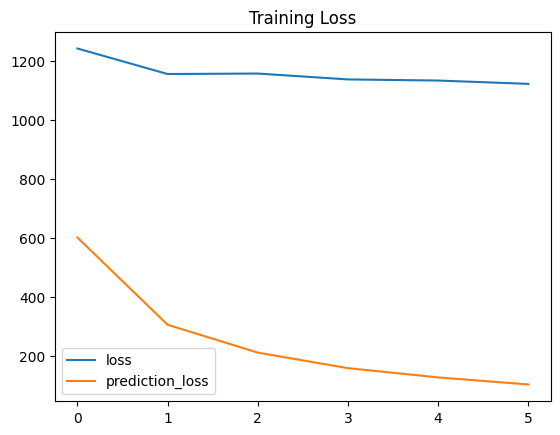

In [14]:

    #     global_step = epoch * len(train_dataloader) + train_step + 1

    #     if global_step % args.log_freq == 0:
    #         save_summary(writer, loss_dict0, global_step, 'train',
    #                         lr=optimizer.param_groups[0]['lr'], 
    #                         momentum=optimizer.param_groups[0]['betas'][0])
    #     train_step += 1

    # training_loss0.append(epoch_loss0)
    # training_gLoss0.append(epoch_gLoss0.detach().cpu())

    # if epoch % 2 == 0:
    #     continue

    # pointpillars.eval()
    # with torch.no_grad():
    #     for i, data_dict in enumerate(tqdm(val_dataloader)):
    #         try:
    #             if not args.no_cuda:
    #                 # move the tensors to the cuda
    #                 for key in data_dict:
    #                     for j, item in enumerate(data_dict[key]):
    #                         if torch.is_tensor(item):
    #                             data_dict[key][j] = data_dict[key][j].cuda()
                
    #             batched_pts = data_dict['batched_pts']
    #             batched_gt_bboxes = data_dict['batched_gt_bboxes']
    #             batched_labels = data_dict['batched_labels']
    #             batched_difficulty = data_dict['batched_difficulty']

    #             bbox_cls_pred0, bbox_pred0, bbox_dir_cls_pred0, anchor_target_dict, x, xe = pointpillars(batched_pts=batched_pts, 
    #                                         batched_pts0=batched_pts0, 
    #                                         mode='train',
    #                                         batched_gt_bboxes=batched_gt_bboxes, 
    #                                         batched_gt_labels=batched_labels)\
    #                 # bbox_cls_pred1, bbox_pred1, bbox_dir_cls_pred1, \
    #                 #     bbox_cls_pred2, bbox_pred2, bbox_dir_cls_pred2,  = \

                
    #             ################# Full features #################
    #             bbox_cls_pred0 = bbox_cls_pred0.permute(0, 2, 3, 1).reshape(-1, args.nclasses)
    #             bbox_pred0 = bbox_pred0.permute(0, 2, 3, 1).reshape(-1, 7)
    #             bbox_dir_cls_pred0 = bbox_dir_cls_pred0.permute(0, 2, 3, 1).reshape(-1, 2)



    #             batched_bbox_labels = anchor_target_dict['batched_labels'].reshape(-1)
    #             batched_label_weights = anchor_target_dict['batched_label_weights'].reshape(-1)
    #             batched_bbox_reg = anchor_target_dict['batched_bbox_reg'].reshape(-1, 7)
    #             batched_dir_labels = anchor_target_dict['batched_dir_labels'].reshape(-1)


                
    #             pos_idx = (batched_bbox_labels >= 0) & (batched_bbox_labels < args.nclasses)

    #             bbox_pred0 = bbox_pred0[pos_idx]


    #             batched_bbox_reg = batched_bbox_reg[pos_idx]
    #             batched_bbox_reg0 = batched_bbox_reg.clone()

    #             # sin(a - b) = sin(a)*cos(b) - cos(a)*sin(b)
    #             bbox_pred0[:, -1] = torch.sin(bbox_pred0[:, -1].clone()) * torch.cos(batched_bbox_reg[:, -1].clone())
    #             batched_bbox_reg0[:, -1] = torch.cos(bbox_pred0[:, -1].clone()) * torch.sin(batched_bbox_reg[:, -1].clone())
    #             bbox_dir_cls_pred0 = bbox_dir_cls_pred0[pos_idx]
    #             batched_dir_labels = batched_dir_labels[pos_idx]
    #             num_cls_pos = (batched_bbox_labels < args.nclasses).sum()
    #             bbox_cls_pred0 = bbox_cls_pred0[batched_label_weights > 0]


    #             batched_bbox_labels[batched_bbox_labels < 0] = args.nclasses
    #             batched_bbox_labels = batched_bbox_labels[batched_label_weights > 0]

    #             loss_dict0 = loss_func(bbox_cls_pred=bbox_cls_pred0,
    #                                     bbox_pred=bbox_pred0,
    #                                     bbox_dir_cls_pred=bbox_dir_cls_pred0,
    #                                     batched_labels=batched_bbox_labels, 
    #                                     num_cls_pos=num_cls_pos, 
    #                                     batched_bbox_reg=batched_bbox_reg0, 
    #                                     batched_dir_labels=batched_dir_labels)
                
                
    #             loss0 = loss_dict0['total_loss'] 
                
    #             gLoss = torch.norm(x-xe)


    #             if not np.isnan(loss0.item()):
    #                 val_epoch_loss0 = val_epoch_loss0 + loss0.item()
    #                 val_epoch_gLoss0 = val_epoch_gLoss0 + lambda_g*gLoss


    #             else:
    #                 continue

    #             global_step = epoch * len(val_dataloader) + val_step + 1
    #             if global_step % args.log_freq == 0:
    #                 save_summary(writer, loss_dict0, global_step, 'val')
    #             val_step += 1
            
    #         except:
    #             None

    # val_loss0.append(val_epoch_loss0)
    # val_gLoss0.append(val_epoch_gLoss0.detach().cpu())
            
    # pointpillars.train()

    # if (epoch + 1) % args.ckpt_freq_epoch == 0:
    #     torch.save(pointpillars.state_dict(), os.path.join(saved_ckpt_path, f'epoch_{epoch+1}.pth'))
    #     checkpoint = {
    #     'epoch': epoch,
    #     'model_state_dict': pointpillars.state_dict(),
    #     'optimizer_state_dict': optimizer.state_dict(),
    #     'loss': loss
    #     }   
    #     torch.save(checkpoint, os.path.join(saved_ckpt_path, f'epoch_{epoch+1}.pth.tar'))
    #     np.save(os.path.join(saved_ckpt_path, f'train_loss.npy'), np.array(training_loss0))
    #     np.save(os.path.join(saved_ckpt_path, f'train_gloss.npy'), np.array(training_gLoss0))
    #     np.save(os.path.join(saved_ckpt_path, f'val_loss.npy'), np.array(val_loss0))
    #     np.save(os.path.join(saved_ckpt_path, f'val_gloss.npy'), np.array(val_gLoss0))

    # if (epoch + 1) % args.plot_freq_epoch == 0:

plt.figure()
plt.plot(np.array(training_loss0))
plt.plot(np.array(training_gLoss0)*0.01)
plt.title("Training Loss")
plt.legend(["loss", "prediction_loss"])
plt.show()

    #     plt.figure()
    #     plt.plot(np.array(val_loss0))
    #     plt.plot(np.array(val_gLoss0))
    #     plt.title("Validation Loss")
    #     plt.legend(["loss","prediction_loss"])
    #     plt.show()